<a href="https://colab.research.google.com/github/aLehav/MLVideoDescriptionResearch/blob/main/BEATs_and_BLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to BEATs Github](https://github.com/microsoft/unilm/tree/master/beats)

[Link to AudioSet](https://ieeexplore-ieee-org.libproxy2.usc.edu/stamp/stamp.jsp?tp=&arnumber=7952261)

In [1]:
!pip install boto3 --quiet
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import sys
import math
import cv2
import torch
import torchaudio
import gc
import json
import os
import tarfile
import tempfile
import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
!pip3 install salesforce-lavis --quiet
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess
!git clone https://github.com/microsoft/unilm.git --quiet
!ls
os.chdir('/content/unilm/beats')
# %cd unilm/beats
from Tokenizers import TokenizersConfig, Tokenizers
from BEATs import BEATs, BEATsConfig
os.chdir('../../')
# %cd ../../
!git clone https://github.com/audioset/ontology.git --quiet
os.chdir('/content/ontology')
# %cd ontology
f = open('ontology.json')
ontology = json.load(f)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/video_summarization/')
sys.path.append('/content/drive/MyDrive/video_summarization/')
# %cd ../drive/MyDrive/video_summarization/
anno = pd.read_csv('ydata-tvsum50-anno.tsv', sep='\t', header=None)
!ls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.8/495.8 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 KB 20.9 MB/s eta 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sample_data  unilm
Mounted at /content/drive
91IHQYk1IQM.mp3					 ontology
91IHQYk1IQM.mp4					 qqR6AEXwxoQ.mp3
91IHQYk1IQM.wav					 qqR6AEXwxoQ.wav
BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt  Tokenizer_iter3_plus_AS2M.pt
BEATs_iter3_plus_AS2M.pt			 ydata-tvsum50-anno.tsv


In [2]:
SAVING_FRAMES_PER_SECOND = 6

Helper Functions

In [3]:
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

Main function to extract the frames from video.



In [4]:
def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

Running the functions to extract videos.



In [5]:
vid_name = "91IHQYk1IQM"
location = vid_name + ".mp4" # put location of video path here
video_file = location
main(video_file)

In [7]:
def loadImg(imgPath):
  return Image.open(requests.get(imgPath, stream=True).raw).convert('RGB')   

In [8]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

## Load pretrained/finetuned BLIP2 captioning model

In [9]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption", model_type="base_coco", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

  0%|          | 0.00/2.50G [00:00<?, ?B/s]

dict_keys(['train', 'eval'])

Generate text description with the model and save it to a list



In [10]:
frames_dir = location.replace('.mp4', '') + "-opencv"
fields = ["Title", "Cap1", "Cap2", "Cap3"]
rows = []
for rawImg in os.listdir(frames_dir):
  procRaw = Image.open(frames_dir + "/" + rawImg).convert("RGB")
  image = vis_processors["eval"](procRaw).unsqueeze(0).to(device)
  rows.append([rawImg] + model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3))

KeyboardInterrupt: ignored

Sort the rows with respect to the frames



In [11]:
sorted(rows, key=lambda x: x[0], reverse=False)

[['frame0-00-00.00.jpg',
  'a man holding up his arms as if to lift a tennis ball with one hand',
  'two elephants walking down the street, as people wait in line',
  'there is a light that is shining in the dark'],
 ['frame0-00-00.17.jpg',
  'a picture taken of an airplane at night',
  'a cat laying down on a window sill',
  'two white flowers with dark background'],
 ['frame0-00-00.33.jpg',
  'the black space in front of the cat is very dark',
  'an empty toilet with a small sink and large mirror',
  'an elephant with large horns and long mane standing in the dark'],
 ['frame0-00-00.50.jpg',
  'black and white photo of an intersection at night',
  'this is a photo taken of a building with some dark buildings',
  'a couple of tall buildings that have dark walls in the background'],
 ['frame0-00-00.67.jpg',
  'the large brown building has a clock on it',
  'the view of the top of several buildings and trees from a distance',
  'city in the dark with skyscrapers and a man on top'],
 ['f

In [12]:
df = pd.DataFrame(rows, columns=fields, dtype=float)
df.to_csv(frames_dir + "_captions.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
checkpoint = torch.load('BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')
cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
def get_top_k_labels(audio_input_16khz, k):
  audio_length = audio_input_16khz.shape[1]
  audio_dim = audio_input_16khz.shape[0]
  padding_mask = torch.zeros(audio_dim,audio_length).bool()

  probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
  for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=k))):
      top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
      return (top5_label, top5_label_prob)

def plot_2_cols(df, lab1, lab2, kind='line'):
  ax = df.plot(y=lab1, legend=False, kind=kind)
  ax2 = ax.twinx()
  df.plot(y=lab2, ax=ax2, legend=False, color="c", kind=kind)
  ax.figure.legend()
  plt.show()

class Video:
  def __init__(self, vid_name):
    self.name = vid_name
    meta = torchaudio.info(vid_name + '.wav') # load in wav fie for number of frames
    self.num_frames = meta.num_frames # get number of frames total
    self.waveform, self.sample_rate = torchaudio.load(vid_name + '.wav')
    self.slice_waveform() # get cut up waveforms
    cap = cv2.VideoCapture(vid_name+'.mp4')
    self.fps = cap.get(cv2.CAP_PROP_FPS) # get fps through openCV
  def slice_waveform(self):
    scaler = 2*self.sample_rate
    i_range = range(math.ceil(self.num_frames/scaler))
    def bot_slice(i):
      return i*scaler
    def top_slice(i):
      return min((i+1)*scaler, self.num_frames)
    self.waveforms = [self.waveform[:,bot_slice(i):top_slice(i)] for i in i_range]
    self.num_slices = len(self.waveforms)
  def get_k_labels(self, k):
    self.k = k
    self.labels = [get_top_k_labels(wave, k) for wave in self.waveforms]
    label_set = [label[0] for label in self.labels]
    ont_index = lambda label: next((i for i, item in enumerate(ontology) if item['id'] == label), -1)
    a = lambda x: [ontology[ont_index(i)]['name'] for i in x]
    self.english_labels = pd.DataFrame([a(label) for label in label_set])
  def get_scores(self):
    vid_anno = anno.loc[anno[0] == self.name]
    a = lambda x: [int(i) for i in x[1][2].split(',')]
    b = lambda x: pd.DataFrame([a(i) for i in vid_anno.iterrows()])
    # def annotation_string_to_numerics(vid_anno): 
      # return pd.DataFrame([a(annotation) for annotation in vid_anno.iterrows()])
    self.ratings = b(vid_anno)
    scaler = 2*self.fps
    i_range = range(1,math.ceil(self.ratings.shape[1]/scaler))
    def bot_slice(i):
      return int(i*scaler)
    # def top_slice(i):
      # return min((i+1)*scaler, ratings.shape[1])

    abs_scorer = lambda i: sum(abs(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1]))
    abs_score_changes = pd.DataFrame([abs_scorer(i) for i in i_range])

    scorer = lambda i: sum(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1])
    score_changes = pd.DataFrame([scorer(i) for i in i_range])

    changes = pd.concat([abs_score_changes, score_changes], axis=1)
    changes.columns = ['Abs Score','Score']
    self.changes = changes

    a = lambda ind, df: pd.Series(df.iloc[ind])
    b = lambda ind, df: len(a(ind, df)) - sum([(item in a(ind+1, df).unique()) for item in a(ind, df)]) 
    label_changes = lambda df: pd.DataFrame([b(i, df) for i in range(df.shape[0]-1)])
    for i in range(1,self.k+1):
      lab_changes = label_changes(self.english_labels.iloc[:,0:i])
      self.changes[str(i)+'Labels'] = lab_changes

    
  # def get_scores(self)
  

In [ ]:
a = Video(vid_name='91IHQYk1IQM')
a.get_k_labels(5)
a.get_scores()

In [ ]:
a.english_labels

,0,1,2,3,4
0,Music,Musical instrument,"Violin, fiddle",Bagpipes,"Wind instrument, woodwind instrument"
1,Music,Musical instrument,"Violin, fiddle",Traditional music,Classical music
2,Music,Bagpipes,Musical instrument,Traditional music,"Wind instrument, woodwind instrument"
3,Music,Traditional music,Musical instrument,"Violin, fiddle",Bowed string instrument
4,Music,Brass instrument,Trumpet,Musical instrument,Traditional music
5,Music,"Violin, fiddle",Musical instrument,Traditional music,Bowed string instrument
6,Music,Traditional music,Bagpipes,Musical instrument,Classical music
7,Music,Musical instrument,Traditional music,Bagpipes,"Violin, fiddle"
8,Music,Musical instrument,Brass instrument,"Violin, fiddle",Trumpet
9,Music,Speech,Singing,Shout,Musical instrument


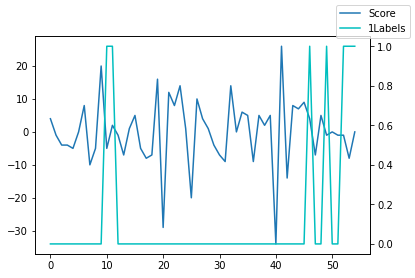

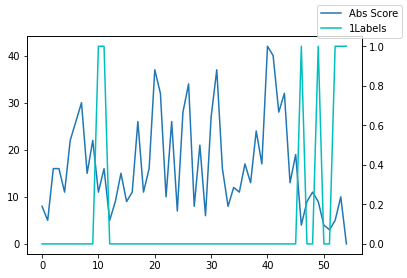

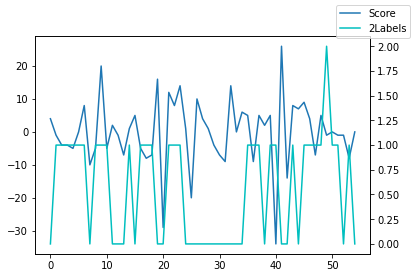

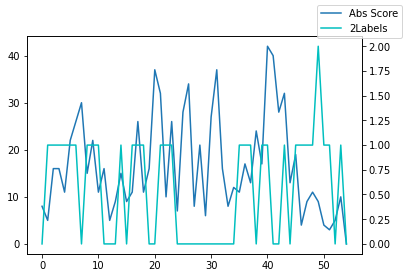

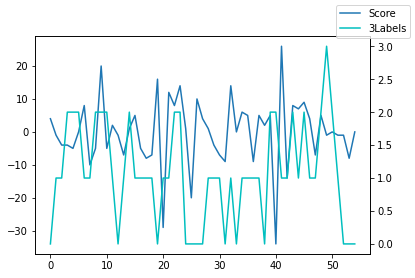

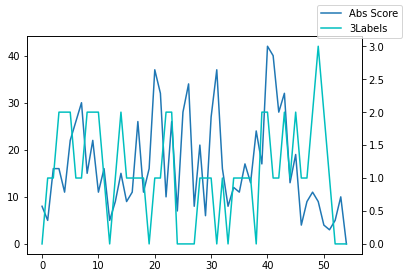

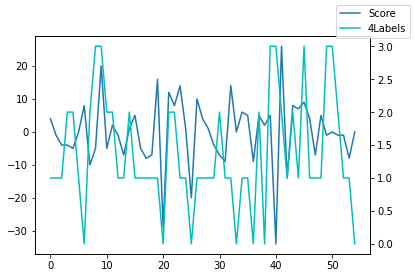

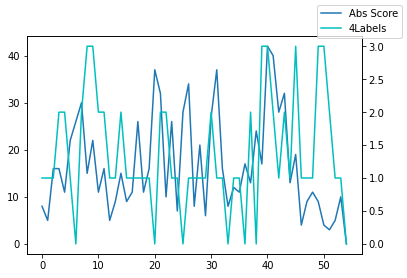

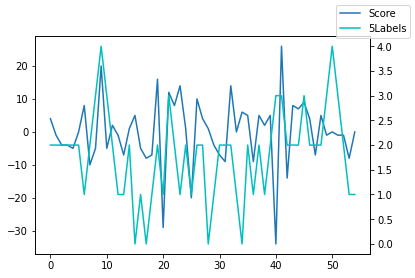

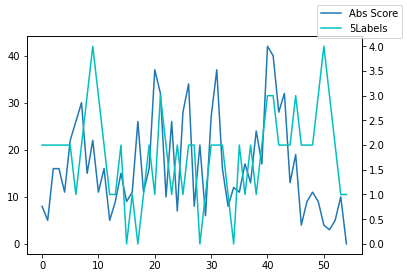

In [ ]:
for i in range(1, a.k+1):
  plot_2_cols(a.changes, 'Score', str(i)+'Labels', kind='line')
  plot_2_cols(a.changes, 'Abs Score', str(i)+'Labels')

<AxesSubplot:ylabel='Abs Score'>

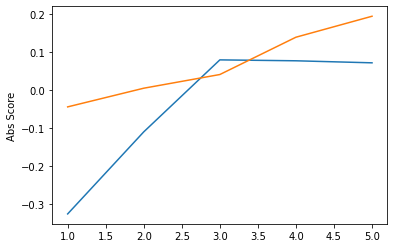

In [ ]:
import seaborn as sn
sn.lineplot(y = a.changes.corr()['Abs Score'][2:], x = range(1, a.k+1))
sn.lineplot(y = a.changes.corr()['Score'][2:], x = range(1, a.k+1))


In [ ]:
a.changes

,Abs Score,Score,1Labels,2Labels,3Labels,4Labels,5Labels
0,8,4,0,0,0,1,2
1,5,-1,0,1,1,1,2
2,16,-4,0,1,1,1,2
3,16,-4,0,1,2,2,2
4,11,-5,0,1,2,2,2
5,22,0,0,1,2,1,2
6,26,8,0,1,1,0,1
7,30,-10,0,0,1,2,2
8,15,-5,0,1,2,3,3
9,22,20,0,1,2,3,4


In [ ]:
a.changes.corr()

,Abs Score,Score,1Labels,2Labels,3Labels,4Labels,5Labels
Abs Score,1.000000,-0.142334,-0.326472,-0.110635,0.078678,0.076272,0.070919
Score,-0.142334,1.000000,-0.044947,0.004166,0.040175,0.138292,0.193438
1Labels,-0.326472,-0.044947,1.000000,0.108275,-0.036578,0.028817,0.077469
2Labels,-0.110635,0.004166,0.108275,1.000000,0.709603,0.466344,0.367912
3Labels,0.078678,0.040175,-0.036578,0.709603,1.000000,0.683025,0.420184
4Labels,0.076272,0.138292,0.028817,0.466344,0.683025,1.000000,0.722225
5Labels,0.070919,0.193438,0.077469,0.367912,0.420184,0.722225,1.000000
